# Random Search

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import roc_curve, recall_score, roc_auc_score, precision_recall_fscore_support, accuracy_score, classification_report, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [2]:
# Załadowanie danych
train_df = pd.read_csv('train_df.csv', index_col=0)
test_df = pd.read_csv('test_df.csv', index_col=0)

# Oznaczenie zbioru treningowego i testowego
train_df['__is_train'] = 1
test_df['__is_train'] = 0

# Połączenie zbiorów
combined = pd.concat([train_df, test_df], axis=0)

# Kodowanie One-Hot Encoding
combined = pd.get_dummies(combined, drop_first=True)
train_df = combined[combined['__is_train'] == 1].drop(columns='__is_train')
test_df = combined[combined['__is_train'] == 0].drop(columns='__is_train')

# Podział na cechy i etykiety
X_train = train_df.drop('stroke', axis=1)
y_train = train_df['stroke']

X_test = test_df.drop('stroke', axis=1)
y_test = test_df['stroke']

In [3]:
# Indeksy cech kategorycznych po One-Hot Encoding
index_of_categorical_features = [1, 2, 5, 6, 7, 8, 9, 10, 11]

# Zastosowanie SMOTENC
sm = SMOTENC(categorical_features=index_of_categorical_features, random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

## Grid Search – dobór optymalnych hiperparametrów

In [4]:
# === GRID SEARCH ===
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=0
)

print("Rozpoczynam Grid Search...")
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepszy wynik AUC na zbiorze walidacyjnym: {grid_search.best_score_}")

# Model z najlepszymi parametrami
best_rf_model = grid_search.best_estimator_

Rozpoczynam Grid Search...
Najlepsze parametry: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Najlepszy wynik AUC na zbiorze walidacyjnym: 0.9091256979222965


In [5]:
# Inicjalizacja modelu z najlepszymi parametrami
best_rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    **grid_search.best_params_
)

# Trenowanie modelu
print("Training the Random Forest model...")
best_rf_model.fit(X_train_resampled, y_train_resampled)

Training the Random Forest model...


RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

## Ocena modelu

In [9]:
y_proba = best_rf_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"TPR (Recall): {recall:.4f}")
print(f"Macro avg Precision: {precision:.4f}")
print(f"Macro avg Recall: {recall_macro:.4f}")
print(f"Macro avg F1-score: {f1_score_macro:.4f}")

Confusion Matrix:
[[738 230]
 [ 18  36]]
Accuracy: 0.7573
AUC: 0.8119
TPR (Recall): 0.6667
Macro avg Precision: 0.5558
Macro avg Recall: 0.7145
Macro avg F1-score: 0.5406


### Ocena dla progu zmniejszonego do 0.3

In [16]:
y_proba = best_rf_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.3).astype(int)

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"TPR (Recall): {recall:.4f}")
print(f"Macro avg Precision: {precision:.4f}")
print(f"Macro avg Recall: {recall_macro:.4f}")
print(f"Macro avg F1-score: {f1_score_macro:.4f}")

Confusion Matrix:
[[530 438]
 [  4  50]]
Accuracy: 0.5675
AUC: 0.8119
TPR (Recall): 0.9259
Macro avg Precision: 0.5475
Macro avg Recall: 0.7367
Macro avg F1-score: 0.4451


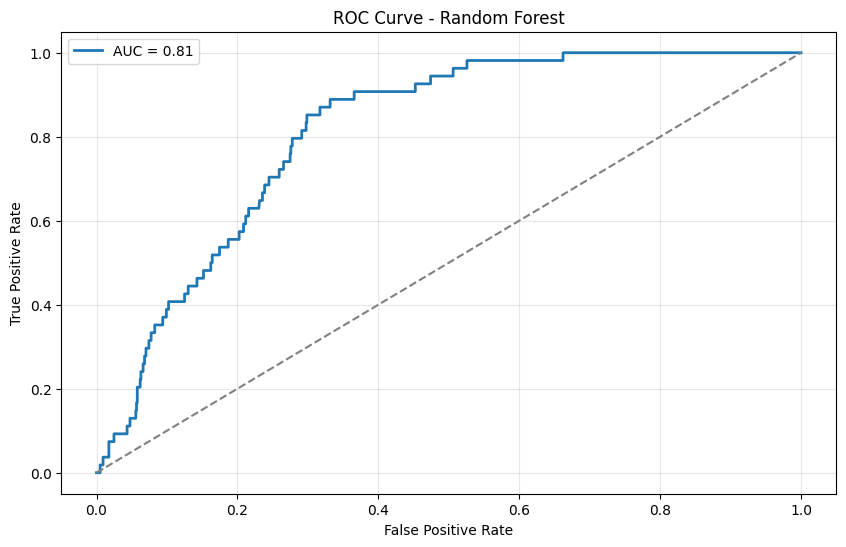

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

# Wizualizacja krzywej ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(auc), linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

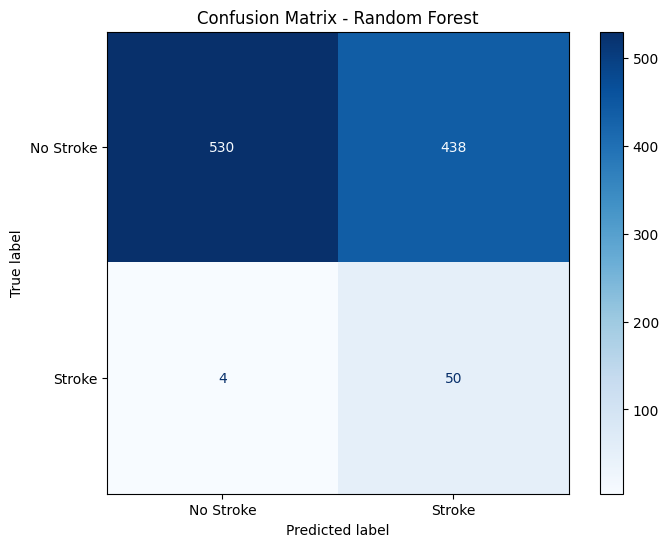

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generowanie confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Stroke", "Stroke"])

# Wykres confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.show()

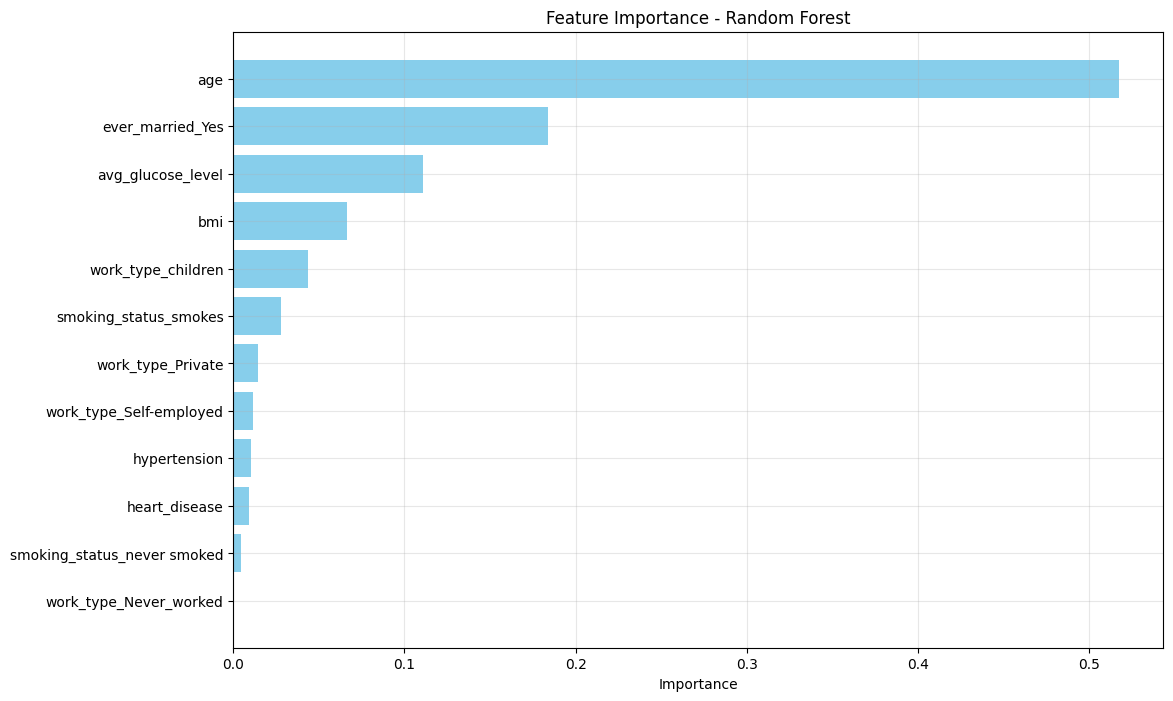

In [19]:
# Feature Importance - Random Forest

# Obliczanie istotności cech
importances = best_rf_model.feature_importances_
features = X_train.columns

# Tworzenie DataFrame dla lepszego sortowania i prezentacji
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Wizualizacja
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()  # Odwrócenie osi Y, aby najważniejsze cechy były na górze
plt.grid(alpha=0.3)
plt.show()


## Podsumowanie metryk

1. AUC: 0.8119
2. TPR (Recall): 0.9259
3. Macro avg Precision: 0.5475
4. Macro avg Recall: 0.7367
5. Macro avg F1-score: 0.4451